In [1]:
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.layers import PReLU

In [2]:
dataset = r'C:\Users\user\Desktop\dataset'
egg = []
speech = []

n = 0
for i in os.listdir(dataset + r"\speech"):
    n += 1
    egg_sample,_ = librosa.load(dataset + r"\egg" + "\\" + i)
    speech_sample,_ = librosa.load(dataset + r"\speech" + "\\" + i)
    egg.append(egg_sample)
    speech.append(speech_sample)
    if n == 500:
        break

In [3]:
egg_dataset = []
speech_dataset = []

window_size = 1000

for i in range(len(egg)):
    for j in range(len(egg[i])//window_size):
        egg_dataset.append(egg[i][window_size*j:window_size*(j+1)])
        speech_dataset.append(speech[i][window_size*j:window_size*(j+1)])
        
del egg,speech

In [4]:
egg_dataset = np.array(egg_dataset)
speech_dataset = np.array(speech_dataset)

In [5]:
n = len(egg_dataset)

X_train = speech_dataset[:int(n*0.95)]
Y_train = egg_dataset[:int(n*0.95)]
X_val = speech_dataset[int(n*0.95):int(n*0.975)]
Y_val = egg_dataset[int(n*0.95):int(n*0.975)]
X_test = speech_dataset[int(n*0.975):]
Y_test = egg_dataset[int(n*0.975):]

del egg_dataset,speech_dataset

In [7]:
input_speech = keras.Input(shape=(window_size,1,))

layer1 = layers.Conv1D(16, 10, strides = 2)(input_speech)
layer1_act = PReLU(alpha_initializer="zeros")(layer1)

layer2 = layers.Conv1D(32, 10, strides = 2)(layer1_act)
layer2_act = PReLU(alpha_initializer="zeros")(layer2)

condensed = layers.Conv1D(64, 10, strides = 2)(layer2_act)

upsample2 = layers.Conv1DTranspose(32, 10, strides = 2)(condensed)
buffer2 = layers.Add()([upsample2,layer2])
upsample2_act = PReLU(alpha_initializer="zeros")(buffer2)

upsample1 = layers.Conv1DTranspose(16, 10, strides = 2)(upsample2_act)
buffer1 = layers.Add()([upsample1,layer1])
upsample1_act = PReLU(alpha_initializer="zeros")(buffer1)

#output_egg = layers.Conv1DTranspose(1, 10, strides = 2)(upsample1_act)
final_1 = layers.Conv1DTranspose(8, 10, strides = 2)(upsample1_act)
final_1_norm = layers.BatchNormalization()(final_1)
final_1_act = PReLU(alpha_initializer="zeros")(final_1_norm)
final_2 = layers.Conv1D(4, 10, padding = "same")(final_1_act)
final_2_norm = layers.BatchNormalization()(final_2)
final_2_act = PReLU(alpha_initializer="zeros")(final_2_norm)
final_egg = layers.Conv1D(1, 10, activation = "tanh",padding = "same")(final_2_act)

auto_model = keras.Model(input_speech, final_egg)
auto_model.compile(optimizer='adam', loss='mse')

In [8]:
auto_model.fit(X_train, Y_train,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(X_val, Y_val))

Epoch 1/10
511/511 [==============================] - 59s 115ms/step - loss: 0.0327 - val_loss: 0.0308
Epoch 2/10
511/511 [==============================] - 56s 109ms/step - loss: 0.0255 - val_loss: 0.0297
Epoch 3/10
511/511 [==============================] - 57s 111ms/step - loss: 0.0248 - val_loss: 0.0292
Epoch 4/10
511/511 [==============================] - 58s 113ms/step - loss: 0.0242 - val_loss: 0.0284
Epoch 5/10
511/511 [==============================] - 61s 119ms/step - loss: 0.0239 - val_loss: 0.0283
Epoch 6/10
511/511 [==============================] - 61s 120ms/step - loss: 0.0236 - val_loss: 0.0285
Epoch 7/10
511/511 [==============================] - 59s 116ms/step - loss: 0.0234 - val_loss: 0.0280
Epoch 8/10
511/511 [==============================] - 59s 116ms/step - loss: 0.0232 - val_loss: 0.0279
Epoch 9/10
511/511 [==============================] - 57s 112ms/step - loss: 0.0231 - val_loss: 0.0278
Epoch 10/10
511/511 [==============================] - 59s 115ms/step - l

In [9]:
print(auto_model.evaluate(X_test,Y_test))

27/27 [==============================] - 0s 14ms/step - loss: 0.0207
0.02067677117884159


In [10]:
out = auto_model.predict(X_test)

input speech


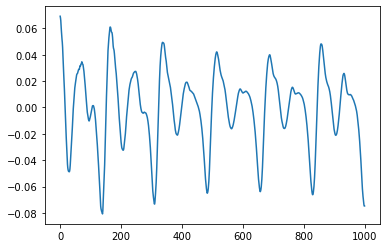

actual egg


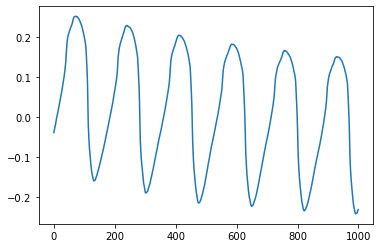

autoencoder-like egg


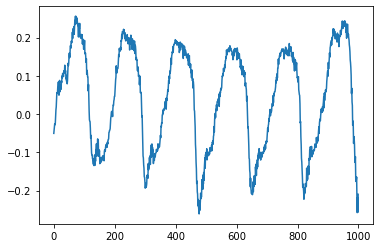

In [13]:
index = 70

print("input speech")
plt.plot(X_test[index])
plt.show()
print("actual egg")
plt.plot(Y_test[index])
plt.show()
print("autoencoder-like egg")
plt.plot(out[index])
plt.show()

In [16]:
auto_model.save(r'C:\Users\user\Desktop\autoencoder_egg')

INFO:tensorflow:Assets written to: C:\Users\user\Desktop\autoencoder_egg\assets
